# Anomaly Detection

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

In [2]:
X_train, X_val, y_val = load_data()

In [4]:
X_train_pd = pd.DataFrame(data=X_train, columns=["throughput_mb_s", "latency_ms"])

X_train_pd.head()

,throughput_mb_s,latency_ms
0,13.046815,14.741152
1,13.408520,13.763270
2,14.195915,15.853181
3,14.914701,16.174260
4,13.576700,14.042849


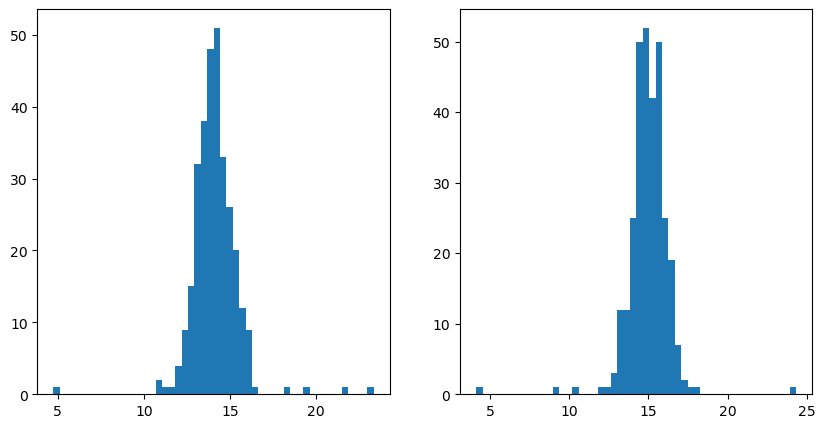

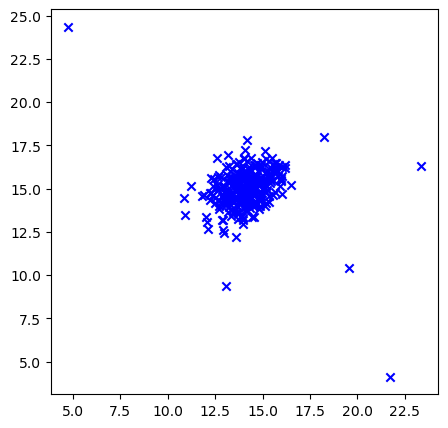

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5));
axs[0].hist(X_train_pd['throughput_mb_s'], bins=50);
axs[1].hist(X_train_pd['latency_ms'], bins=50);

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X_train_pd['throughput_mb_s'], X_train_pd['latency_ms'], marker='x', c='b')


In [27]:
def estimate_gaussian(X):
  m, n = X.shape

  mu = (1/m) * np.sum(X, axis=0)
  var = (1/m) * np.sum((X - mu)**2, axis=0)

  return mu, var

In [28]:
import public_tests

mu, var = estimate_gaussian(X_train)
print(f'mu for X_train = {mu}')
print(f'var for X_train = {var}')

public_tests.estimate_gaussian_test(estimate_gaussian)

mu for X_train = [14.11222578 14.99771051]
var for X_train = [1.83263141 1.70974533]
All tests passed!


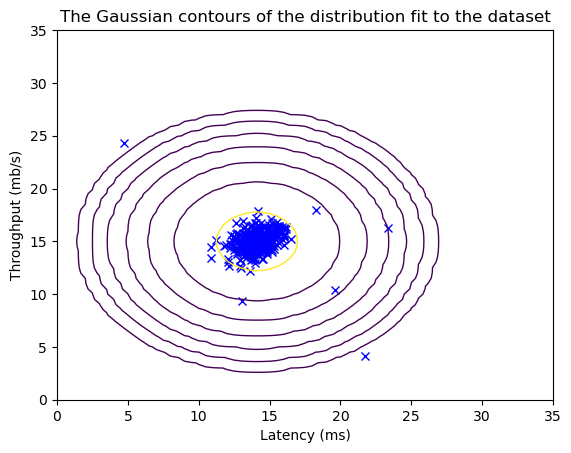

In [29]:
from utils import multivariate_gaussian, visualize_fit

p = multivariate_gaussian(X_train, mu, var)

visualize_fit(X_train, mu, var)

In [49]:
def select_threshold(y_val, p_val):
  best_epsilon = 0
  best_F1 = 0
  F1 = 0
  
  step_size = (max(p_val) - min(p_val)) / 1000
  
  for epsilon in np.arange(min(p_val), max(p_val), step_size):
    # Calculates predictions of each probability: if p < epsilon then true (anomaly) else false
    # p is an array of probabilities (one for each element in the validation set)
    predictions = p_val < epsilon
    # number of true positives
    n_true_positives = np.sum((predictions == 1) & (y_val == 1))
    n_false_positives = np.sum((predictions == 1) & (y_val == 0))
    n_false_negatives = np.sum((predictions == 0) & (y_val == 1))

    precision  = n_true_positives / (n_true_positives + n_false_positives)
    recall = n_true_positives / (n_true_positives + n_false_negatives)
    f1 = 2 * precision * recall / (precision + recall)

    if f1 > F1:
      F1 = f1
      best_epsilon = epsilon
  
  return best_epsilon, F1


In [50]:
# np.sum((y_val == 1) & (np.full((y_val.shape), True)))

In [51]:
p = multivariate_gaussian(X_val, mu, var)

epsilon, F1 = select_threshold(y_val, p)

print(f'Best epsilon from validation set: {epsilon}')
print(f'Best F1 score from validation set: {F1}')

from public_tests import select_threshold_test

select_threshold_test(select_threshold)

Best epsilon from validation set: 8.990852779269493e-05
Best F1 score from validation set: 0.8750000000000001
All tests passed!


/tmp/ipykernel_10643/350864462.py:17: RuntimeWarning: invalid value encountered in scalar divide
  precision  = n_true_positives / (n_true_positives + n_false_positives)


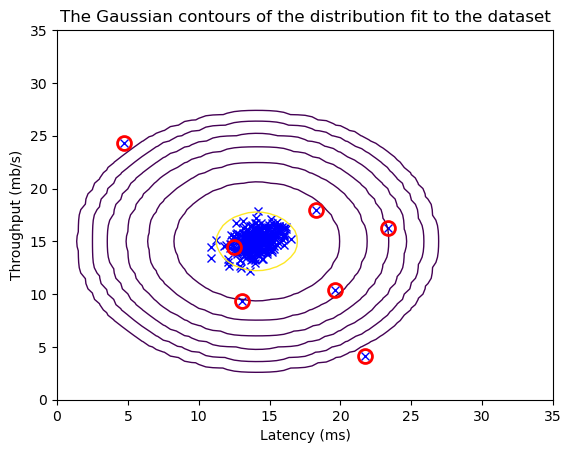

In [53]:
outliers = p < epsilon

visualize_fit(X_train, mu, var)

plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
  markersize= 10,markerfacecolor='none', markeredgewidth=2)